<a href="https://colab.research.google.com/github/AWHochman/cds_sp23/blob/main/optimal_portfolio_testing_samara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
from pandas_datareader import data as web
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta 
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
from statistics import mean 
import datetime as dt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [237]:
#A class representing a porfolio of stocks 

class Portfolio():
  def __init__(self, assets, startdate, startmoney):
    self.assets = assets
    self.startdate = startdate
    self.startmoney = startmoney
    self.prev_weights = np.zeros(len(self.assets))
    self.df = self.get_data(self.startdate, self.today_date())
  
  # Returns today's date in a string format 
  def today_date(self):
    today = datetime.today().strftime('%Y-%m-%d')
    return today

  # function to pull stock data from yfinance
  # assets is a list of stock tickers (as strings), start is the starting date, and end is the ending date
  def get_data(self, start, end):
    print('beg of get_data')
    df=pd.DataFrame()
    for stock in self.assets:
      df[stock]= yf.download(stock, start=start, end=end)['Adj Close']
    print('end of get_data')
    return df

  def get_returns(self, start, end):
    print('in get_returns')
    return self.df.loc[start:end]
    

  # Portfolio Optimization
  # function that finds the optimal weights (and returns them in an array) for each stock. df is a data frame of daily stock prices
  def get_weights(self,start,end,assets):
    print('beg of get_weights')
    dfSubset = self.get_returns(start, end)

    # Calculate the expected returns and the annualized sample covariance matrix of asset returns
    mean = expected_returns.mean_historical_return(dfSubset)
    S = risk_models.sample_cov(dfSubset)

    # Optimize for max sharpe ratio
    # Sharpe Ratio: A way to describe how much excess return you recieve for the extra amount of volatility you add. 
    try:
      ef = EfficientFrontier(mean, S)
      weights = ef.max_sharpe() #risk_free_rate = .02/253
      cleaned_weights = ef.clean_weights()

      cleaned_weights_array = [] 
      for key, value in cleaned_weights.items():
        cleaned_weights_array.append(value)
      self.prev_weights = cleaned_weights_array
      return cleaned_weights_array
      print('end of try')
    except:
      print('in except')
      return self.prev_weights


  # returns an array with how many shares of each stock should be bought
  # df is a data frame of daily stock prices, weights is an array with weights of each stock in df, and money is how much money you can invest
  def find_discrete_allocation(self,df, weights, money,date):
    print('beg of dis allocation')
    prices = self.get_prices_at_valid_date(df,date)
    spend = np.dot(money,weights) #how much you can spend on each stock 
    num = [] # how much of each stock to buy
    for i in range(len(weights)):
      num.append(np.floor(spend[i]/prices[i]))
    print('end of dis allocation')
    return num


  # finds left over money after investing in the portfolio
  # num_stocks is the number of shares of each stock bought
  # df must be updated (have today's prices)
  def find_money_left_over(self,allocation, df, cash,date):
    prices = self.get_prices_at_valid_date(df,date)
    spent = np.dot(allocation, prices)
    sum = spent.sum()
    return cash - sum


  #meant to be run after a cycle when rebalancing
  #gets total amount from selling portfolio plus our left over money 
  def get_new_total(self,allocation, df, extra_cash,date):
    prices = self.get_prices_at_valid_date(df,date)
    sales = spend = np.dot(allocation, prices)
    sum = sales.sum()
    return sum + extra_cash


  # Compares the initial amount (start) and the final amount (end). 
  # If it is a 20% increase: 1.2
  # If it is a 10% decrease: 0.9
  def compare(self, start,end):
    profit = end - start
    return 1 + (profit/start)


  # Return the prices of all the assets on a given date. 
  # date must be a valid trading date or else the function will return False. 
  def get_prices_at_valid_date(self, df,date):
    #print(type(df.ffill().iloc[1].name))
    for ind in range(df.shape[0]):
      if (str(df.ffill().iloc[ind].name) == date + ' 00:00:00'):
        return df.ffill().iloc[ind]

    return False


  # Return a valid trading date: date + 'date_range' number of trading days.  
  # date_range can be negative
  # If the new date is outside of the range of the dataframe, the function returns "OutOfRange"
  # If the input date is not a valid trading date, the function returns False.
  def return_date_after_range(self, df,date,date_range):
    for ind in range(df.shape[0]):
      if (str(df.ffill().iloc[ind].name) == date + ' 00:00:00'):
        try:
          aString = str(df.ffill().iloc[ind + date_range].name)
        except:
          return 'OutOfRange'
        split = aString.split()
        return split[0]

    return False


  # Back-tests one trade and compares the input and output. 
  # startDate is the date where you start collecting data
  # dataRange is the range of trading days where you collect data before allocating weights and buy stocks
  # shiftRange is the frequency of resetting the portfolio. (in number of trading days)
  # *The stocks are sold on the date: startDate + dataRange + shiftRange

  def backTest(self, df,assets,startMoney,startDate,dataRange,shiftRange):
    print('beg of backTest')
    endDate = self.return_date_after_range(df,startDate,dataRange)

    weights = self.get_weights(startDate, endDate, assets)
  

    allocation = self.find_discrete_allocation(df, weights, startMoney,endDate)

    cash = self.find_money_left_over(allocation, df, startMoney,endDate)

    total = self.get_new_total(allocation, df, cash, self.return_date_after_range(df,endDate,shiftRange) )
    print('end of backtest')
    return self.compare(startMoney,total)


  # Loops the backTest from 'startDate' to today (or the closest trading day consistant with the rebalancing frequency)
  # The portfolio is rebalanced every 'shiftRange' trading days. 
  # Return: Compares the initial value '1' and the final value
  # * If the output is '2', the value doubled in total. 
  def backTestLoop(self, df, assets, startMoney, startDate, dataRange, shiftRange):
    print('beg of back test loop')

    returnValue = self.backTest(df,assets,startMoney,startDate,dataRange,shiftRange)

    while self.return_date_after_range(df,startDate, dataRange + shiftRange + shiftRange) != 'OutOfRange':
      sellDate = self.return_date_after_range(df,startDate,dataRange + shiftRange)
      print(sellDate)
    
      startDate = self.return_date_after_range(df,startDate,shiftRange)

      returnValue = returnValue * self.backTest(df,assets,startMoney,startDate,dataRange, shiftRange)

      #print(returnValue)
    
    #return str(returnValue) + ' => Last Sold On : ' + str(sellDate)
    print('end of back test loop')
    return returnValue

  # Back-tests by keeping the weights equal and constant. 
  # This is used to compare results with the optimization program. 
  def equal_weights_test(self,endDate):
    change_list = []
    if (self.get_prices_at_valid_date(self.df,endDate) == False):
      endDate = (datetime.strptime(endDate, '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')

    for x in range(len(self.assets)):
      change_list.append(self.get_prices_at_valid_date(self.df,endDate)[x]/self.get_prices_at_valid_date(self.df,self.startdate)[x])

    return mean(change_list)

  def test(self, datarange, shiftrange):


    solution = self.backTestLoop(self.df, self.assets, self.startmoney, self.startdate, datarange, shiftrange)
    return solution



In [238]:
#Set up FAANG Portfolio
assets = ['META', 'AMZN', 'AAPL','NFLX','GOOG']
startDate = '2018-01-02' # Date to start collecting data. Must be a valid trading date or there will be an error. 
startMoney = 100000
shiftRange = 1
dataRange = 100
port1 = Portfolio(assets, startDate, startMoney)

beg of get_data
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
end of get_data


In [239]:
#testing different rebalancing frequencies 
dataRange = 100
shiftRange = [1,5,10,20,50,100,200]
results = []
for i in shiftRange:
 results.append(port1.test(dataRange, i))



beg of back test loop
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2018-05-29
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2018-05-30
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2018-05-31
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2018-06-01
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2018-06-04
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2018-06-05
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2018-06-06
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2018-06-07
beg of bac

KeyboardInterrupt: ignored

In [ ]:
#comparing to investing in equal weights the whole time
print(port1.equal_weights_test(port1.today_date()))

2.1257616463906737


In [ ]:
print(results)

[3.5731083597883724, 3.2044813547368163, 3.097652838206068, 2.6886694420363275, 2.7595596480180054, 2.2338981583327207, 1.551373585986246]


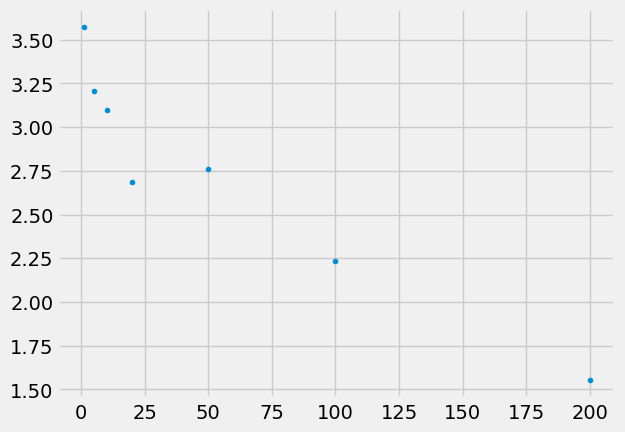

In [ ]:
plt.plot(shiftRange, results, '.')

In [ ]:
#testing different data lookback periods
dataRange = [10,20,50,100,200, 300]
shiftRange = 10
results = []
equal = []
for i in dataRange:
 results.append(port1.test(i, shiftRange))



NameError: ignored

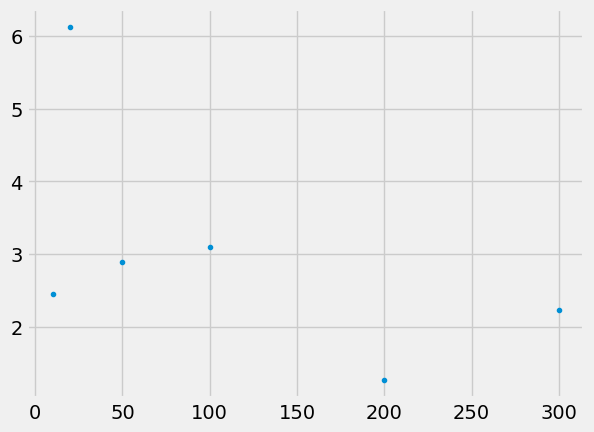

In [ ]:
plt.plot(dataRange, results, '.')

In [ ]:
print(results)

[2.4454212084269895, 6.1279835865724115, 2.8972110673403093, 3.0976512983299513, 1.258984548274778, 2.2364257927944062]


In [ ]:
print(port1.test(20, 1))

Streaming output truncated to the last 5000 lines.
end of backtest
2020-07-08
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2020-07-09
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2020-07-10
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2020-07-13
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2020-07-14
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2020-07-15
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2020-07-16
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end of dis allocation
end of backtest
2020-07-17
beg of backTest
beg of get_weights
in get_returns
beg of dis allocation
end

In [234]:
#A class representing a porfolio of stocks --> currently not working 

class Sector_Portfolio():

  def __init__(self, sectors, startdate, startmoney):
    self.assets = sectors
    self.startdate = startdate
    self.startmoney = startmoney
    self.prev_weights = np.zeros(len(self.assets))
    self.df = self.get_sector_data(self.startdate, self.latest_date())

  COMM = 'Communication'
  UTIL = 'Utilities'  
  ENER = 'Energy'
  RE = 'Real_Estate'
  CONS = 'Cons_Staples'
  HC = 'Healthcare'
  FIN = 'Financials'
  IND = 'Industrials'
  MAT = 'Materials'
  COND = 'Cons_Disc'
  IT = 'Info_Tech'
  
  SECTOR_TO_DF = {
    COMM: Comm_df,
    UTIL: Utilities_df,
    ENER: Energy_df,
    RE: RealEstate_df,
    CONS: ConsS_df,
    HC: Healthcare_df,
    FIN: Financials_df,
    IND: Industrials_df,
    MAT: Materials_df,
    COND: ConsD_df,
    IT: IT_df
  }


  
  # Returns today's date in a string format 
  def latest_date(self):
    return str(df.tail(1).index[0])
 

  def get_sector_data(self, start, end):
    df = pd.DataFrame()
    for sector in self.assets:
      data = SECTOR_TO_DF[sector].set_index(['Effective date '])
      df[sector] = data.loc[start:end]
    return df

  def get_returns(self, start, end):
    print('in get_returns')
    return self.df.loc[start:end]
    

  # Portfolio Optimization
  # function that finds the optimal weights (and returns them in an array) for each stock. df is a data frame of daily stock prices
  def get_weights(self,start,end,assets):
    print('beg of get_weights')
    dfSubset = self.get_returns(start, end)
    print('after get returns')
    # Calculate the expected returns and the annualized sample covariance matrix of asset returns
    mean = expected_returns.mean_historical_return(dfSubset)
    S = risk_models.sample_cov(dfSubset)

    # Optimize for max sharpe ratio
    # Sharpe Ratio: A way to describe how much excess return you recieve for the extra amount of volatility you add. 
    try:
      ef = EfficientFrontier(mean, S)
      weights = ef.max_sharpe() #risk_free_rate = .02/253
      cleaned_weights = ef.clean_weights()

      cleaned_weights_array = [] 
      for key, value in cleaned_weights.items():
        cleaned_weights_array.append(value)
      self.prev_weights = cleaned_weights_array
      return cleaned_weights_array
      print('end of try')
    except:
      print('in except')
      return self.prev_weights


  # returns an array with how many shares of each stock should be bought
  # df is a data frame of daily stock prices, weights is an array with weights of each stock in df, and money is how much money you can invest
  def find_discrete_allocation(self,df, weights, money,date):
    print('beg of dis allocation')

    prices = self.get_prices_at_valid_date(df,date) 

    print(' PRICES' + str(prices))
    spend = np.dot(money,weights) #how much you can spend on each stock 
    num = [] # how much of each stock to buy
    for i in range(len(weights)):
      num.append(np.floor(spend[i]/prices[i]))
    print('end of dis allocation')
    return num


  # finds left over money after investing in the portfolio
  # num_stocks is the number of shares of each stock bought
  # df must be updated (have today's prices)
  def find_money_left_over(self,allocation, df, cash,date):
    prices = self.get_prices_at_valid_date(df, date) 
    spent = np.dot(allocation, prices)
    sum = spent.sum()
    return cash - sum


  #meant to be run after a cycle when rebalancing
  #gets total amount from selling portfolio plus our left over money 
  def get_new_total(self,allocation, df, extra_cash,date):
    prices = self.get_prices_at_valid_date(df, date)
    sales = spend = np.dot(allocation, prices)
    sum = sales.sum()
    return sum + extra_cash


  # Compares the initial amount (start) and the final amount (end). 
  # If it is a 20% increase: 1.2
  # If it is a 10% decrease: 0.9
  def compare(self, start,end):
    profit = end - start
    return 1 + (profit/start)


  # Return the prices of all the assets on a given date. 
  # date must be a valid trading date or else the function will return False. 
  def get_prices_at_valid_date(self, df,date):
    #print(type(df.ffill().iloc[1].name))
    for ind in range(df.shape[0]):
      if (str(df.ffill().iloc[ind].name) == date):
        return df.ffill().iloc[ind]

    return False

    
    

  # Return a valid trading date: date + 'date_range' number of trading days.  
  # date_range can be negative
  # If the new date is outside of the range of the dataframe, the function returns "OutOfRange"
  # If the input date is not a valid trading date, the function returns False.
  def return_date_after_range(self, df,date,date_range):
    for ind in range(df.shape[0]):
      #if (str(df.ffill().iloc[ind].name) == date + ' 00:00:00'): ###################
      if (str(df.ffill().iloc[ind].name) == date):
        print('past if')
        try:
          aString = str(df.ffill().iloc[ind + date_range].name)
        except:
          return 'OutOfRange'
        split = aString.split()
        return split[0]

    return False


  # Back-tests one trade and compares the input and output. 
  # startDate is the date where you start collecting data
  # dataRange is the range of trading days where you collect data before allocating weights and buy stocks
  # shiftRange is the frequency of resetting the portfolio. (in number of trading days)
  # *The stocks are sold on the date: startDate + dataRange + shiftRange

  def backTest(self, df,assets,startMoney,startDate,dataRange,shiftRange):
    print('beg of backTest')
    endDate = self.return_date_after_range(df,startDate,dataRange)

    print('final end date ' + endDate)
    weights = self.get_weights(startDate, endDate, assets)
  

    allocation = self.find_discrete_allocation(df, weights, startMoney,endDate)

    cash = self.find_money_left_over(allocation, df, startMoney,endDate)

    total = self.get_new_total(allocation, df, cash, self.return_date_after_range(df,endDate,shiftRange) )
    print('end of backtest')
    return self.compare(startMoney,total)


  # Loops the backTest from 'startDate' to today (or the closest trading day consistant with the rebalancing frequency)
  # The portfolio is rebalanced every 'shiftRange' trading days. 
  # Return: Compares the initial value '1' and the final value
  # * If the output is '2', the value doubled in total. 
  def backTestLoop(self, df, assets, startMoney, startDate, dataRange, shiftRange):
    print('beg of back test loop')

    returnValue = self.backTest(df,assets,startMoney,startDate,dataRange,shiftRange)

    while self.return_date_after_range(df,startDate, dataRange + shiftRange + shiftRange) != 'OutOfRange':
      sellDate = self.return_date_after_range(df,startDate,dataRange + shiftRange)
      print(sellDate)
    
      startDate = self.return_date_after_range(df,startDate,shiftRange)

      returnValue = returnValue * self.backTest(df,assets,startMoney,startDate,dataRange, shiftRange)

      #print(returnValue)
    
    #return str(returnValue) + ' => Last Sold On : ' + str(sellDate)
    print('end of back test loop')
    return returnValue

  # Back-tests by keeping the weights equal and constant. 
  # This is used to compare results with the optimization program. 
  def equal_weights_test(self,endDate):
    change_list = []
    while (self.get_prices_at_valid_date(self.df,endDate) == False): 
      endDate = (datetime.strptime(endDate, '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')

    for x in range(len(self.assets)):
      change_list.append(self.get_prices_at_valid_date(self.df,endDate)[x]/self.get_prices_at_valid_date(self.df,self.startdate)[x])

    return mean(change_list)

  def test(self, datarange, shiftrange):

    solution = self.backTestLoop(self.df, self.assets, self.startmoney, self.startdate, datarange, shiftrange)
    return solution


In [1]:
#Set up Sector Portfolio
sectors = ['Communication','Utilities','Energy']
startDate = '2014-01-03' # Date to start collecting data. Must be a valid trading date or there will be an error. 
startMoney = 100000
shiftRange = 100
dataRange = 100
port2 = Sector_Portfolio(sectors, startDate, startMoney)
#port2.get_returns(startDate, port2.latest_date())
#print(port2.test(dataRange, shiftRange))
#port2.return_date_after_range(port2.get_returns(startDate, port2.latest_date()),startDate, 1000)
port2.get_prices_at_valid_date(port2.get_returns(startDate, port2.latest_date()), '2014-01-02') 

NameError: ignored